Code to investigate the predictive models


In [114]:
#Read in the packages to use
import numpy as np
import pandas as pd
import math
import datetime
import os
import pathlib
import matplotlib.pyplot as plt
import earthpy as et
import pandas as pd
import pickle
#for displaying the cities on map
import cartopy
import cartopy.crs as ccrs

#models
from sklearn.linear_model import LinearRegression 
import statsmodels.api as sm                                          #stats models to get linear reg p-values
from statsmodels.tools.eval_measures import rmse                      #calc rmse from stats models
import itertools                                                      #for calculating possible combinations of variables
from sklearn.preprocessing import PolynomialFeatures                  #for polynomial regression
from sklearn.pipeline import make_pipeline                            #pipeline to create polynomial regression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF                      #import the kernels for GPR
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
#use grid search to find hyperparameters (pg 73 Geron) RFR
from sklearn.model_selection import GridSearchCV                      #for cross validation
from sklearn.feature_selection import RFE                             #for selecting features for the linear reg
from sklearn.model_selection import cross_val_score                   #for cross validation
from sklearn.model_selection import KFold                            
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler                      #for normalising the data
from sklearn.metrics import r2_score                                  #metrics for assessing model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#for plotting
from matplotlib import ticker 
from matplotlib.ticker import MaxNLocator                             #to keep whole numbers on the x-axis
from matplotlib.lines import Line2D                                   #for manual legend creation

#Read in the data

#read in the city info table
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=None)

#remove cities with area of less than 10km2
CITY_COUNTRY_lat_lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['Area_2002']>9].reset_index()

#read the table with all variables in as pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
with open('aqua_all_monthly_data_df2.pkl', 'rb') as f:
    all_monthly_data_df = pickle.load(f)

#remove nans
#all_monthly_data_df = all_monthly_data_df[(~np.isnan(all_monthly_data_df['rur_mean_evi'])
#                    ) & (~np.isnan(all_monthly_data_df['urb_mean_evi'])
#                    ) & (~np.isnan(all_monthly_data_df['a0']))].copy()

#add evi difference variable
all_monthly_data_df['evi_diff'] = all_monthly_data_df['rur_mean_evi'] - all_monthly_data_df['urb_mean_evi']

#add in the log_area_x_ef variable 
all_monthly_data_df['log10_area'] = np.log10(all_monthly_data_df.Area.values.astype(float))
all_monthly_data_df['log_area_x_rur_ef'] = (all_monthly_data_df.log10_area) * (all_monthly_data_df.annual_rural_ef)
all_monthly_data_df['log_area_x_urb_ef'] = (all_monthly_data_df.log10_area) * (all_monthly_data_df.annual_urban_ef)

#split into training and test data
#take the test data as 4 cities, the training as 14?
#or test as 3 cities, training as 15

#define the test cities to remove
test_cities = ['Piracicaba', 'Ndola','Akola','Saki','Muzaffarnagar','Buraydah','Nyala','Cascavel','Bikaner']

#define the overpass time 
overpass_time = '13:30'


#define the predictor and target values for training and test data
#what predictors to use?
predictor_variables_all = ['urban_evap_fract', 'urban_rh', 'rural_evap_fract', 'rural_rh', 'rural_tp', 'urban_tp', 
                           'rural_t2m', 'urban_t2m','rural_ssr', 'urban_ssr','rur_mean_evi', 'urb_mean_evi',
                          'log_area_x_rur_ef','log_area_x_urb_ef','Eccentricity']

#predictor_variables = ['rur_mean_evi', 'urb_mean_evi','log_area_x_urb_ef','rural_rh' ]
#predictor_variables = ['urban_evap_fract','rural_evap_fract']

predictor_variables = predictor_variables_all

target_variable = 'a0'
#target_variable = 'method_2_SUHI'
#target_variable = 'quantile_a0'

#clean the data - first remove columns which are not the target or predictor variables, then remove nans
variables = predictor_variables.copy()
variables.append(target_variable)
variables.append('City')
variables.append('Overpass')
all_monthly_data_df2 = all_monthly_data_df[variables]
all_monthly_data_df2 = all_monthly_data_df2.dropna()

#create training and test datasets
training_data = all_monthly_data_df2[((~all_monthly_data_df2['City'].isin(test_cities)) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
test_data = all_monthly_data_df2[((all_monthly_data_df2['City'].isin(test_cities))
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

print('Train_percent', 100* len(training_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))
print('Test_percent', 100* len(test_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))
print('Total Datapoints',len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))

#split the data into training and test

X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

#get the groups
groups_train = training_data.City
groups_test = test_data.City

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only
y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only


Train_percent 81.48148148148148
Test_percent 18.51851851851852
Total Datapoints 7911


View Train and Test cities

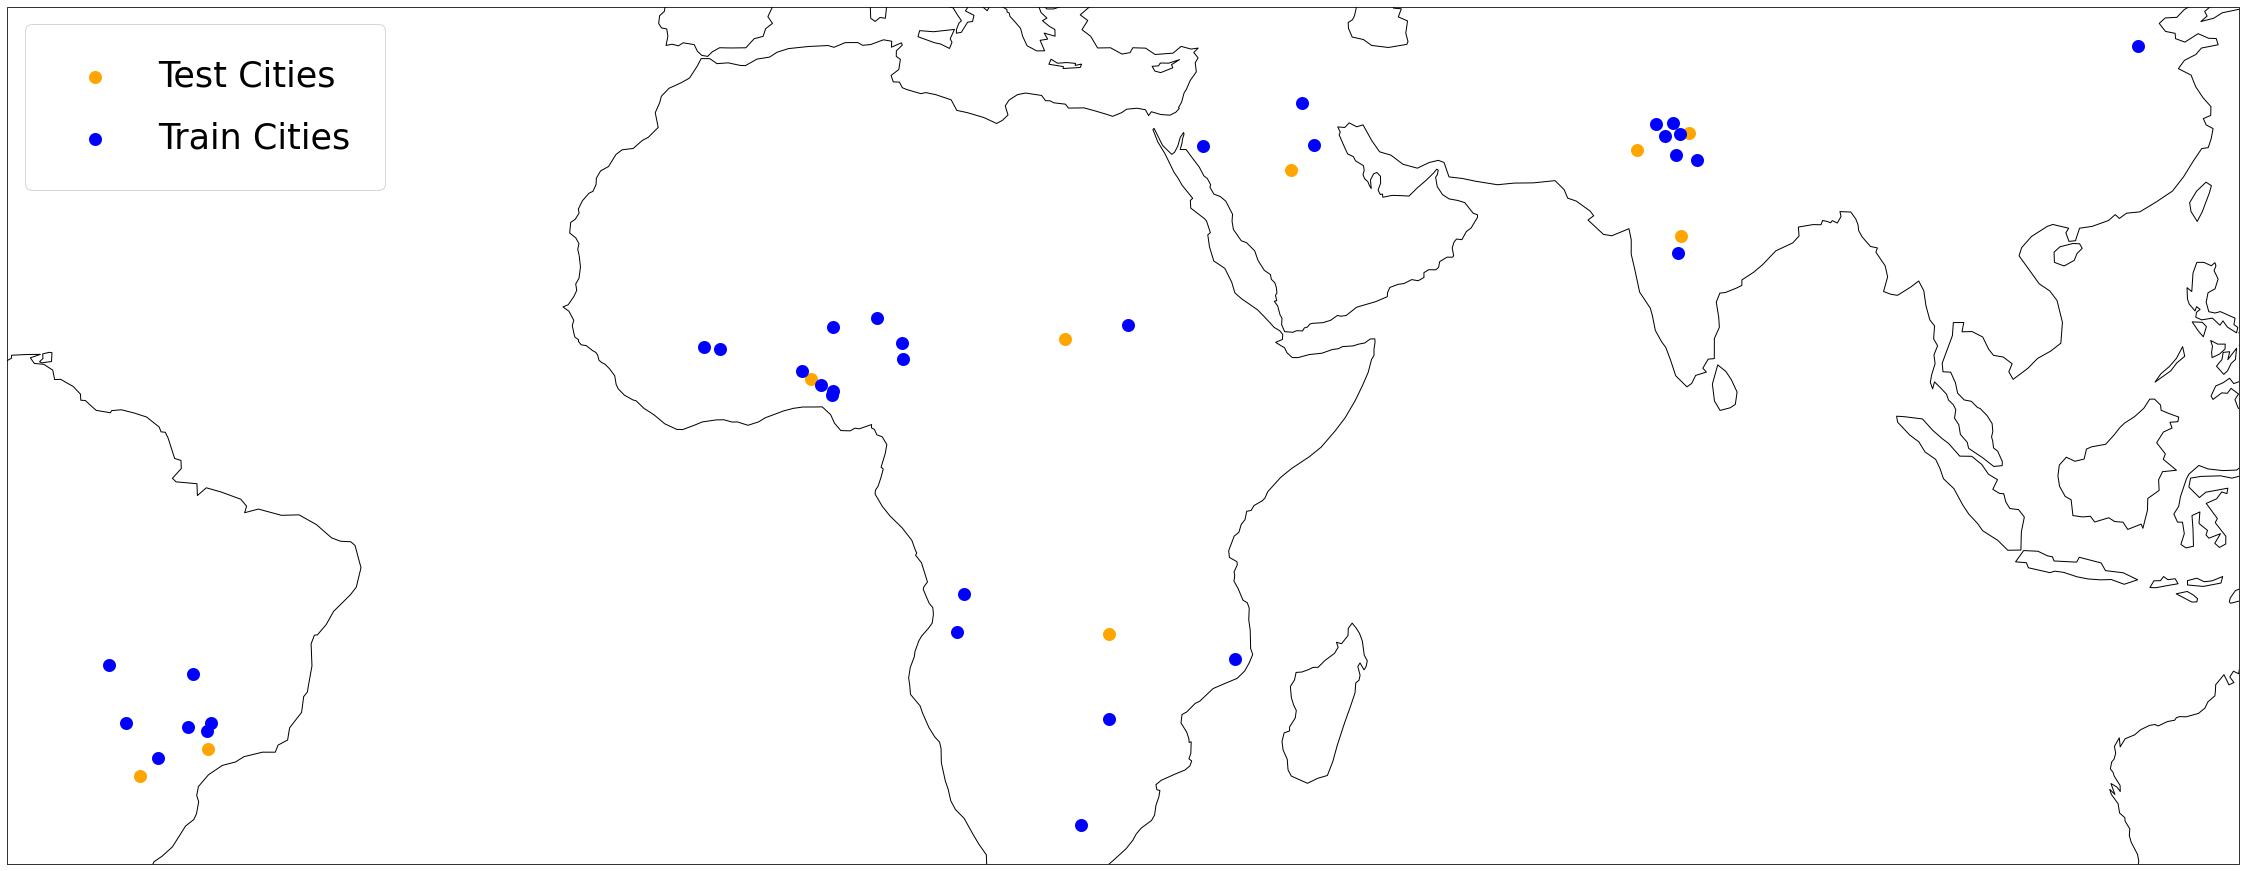

In [2]:
#Display train and test cities
#plot of where the test and training cities are located
fig = plt.figure(figsize=(40,35))

test_lats = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lat']
test_lons = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lon']

train_lats = CITY_COUNTRY_lat_lon[~CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lat']
train_lons = CITY_COUNTRY_lat_lon[~CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lon']

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.scatter(test_lons, test_lats, zorder=5,color='orange', label='Test Cities', linewidths = 7.0)
ax.scatter(train_lons, train_lats, zorder=5,color='blue', label='Train Cities', linewidths = 7.0)

ax.legend(loc=2, borderpad = 1, fontsize = 35, labelspacing=0.8)

Muliple Linear Regression

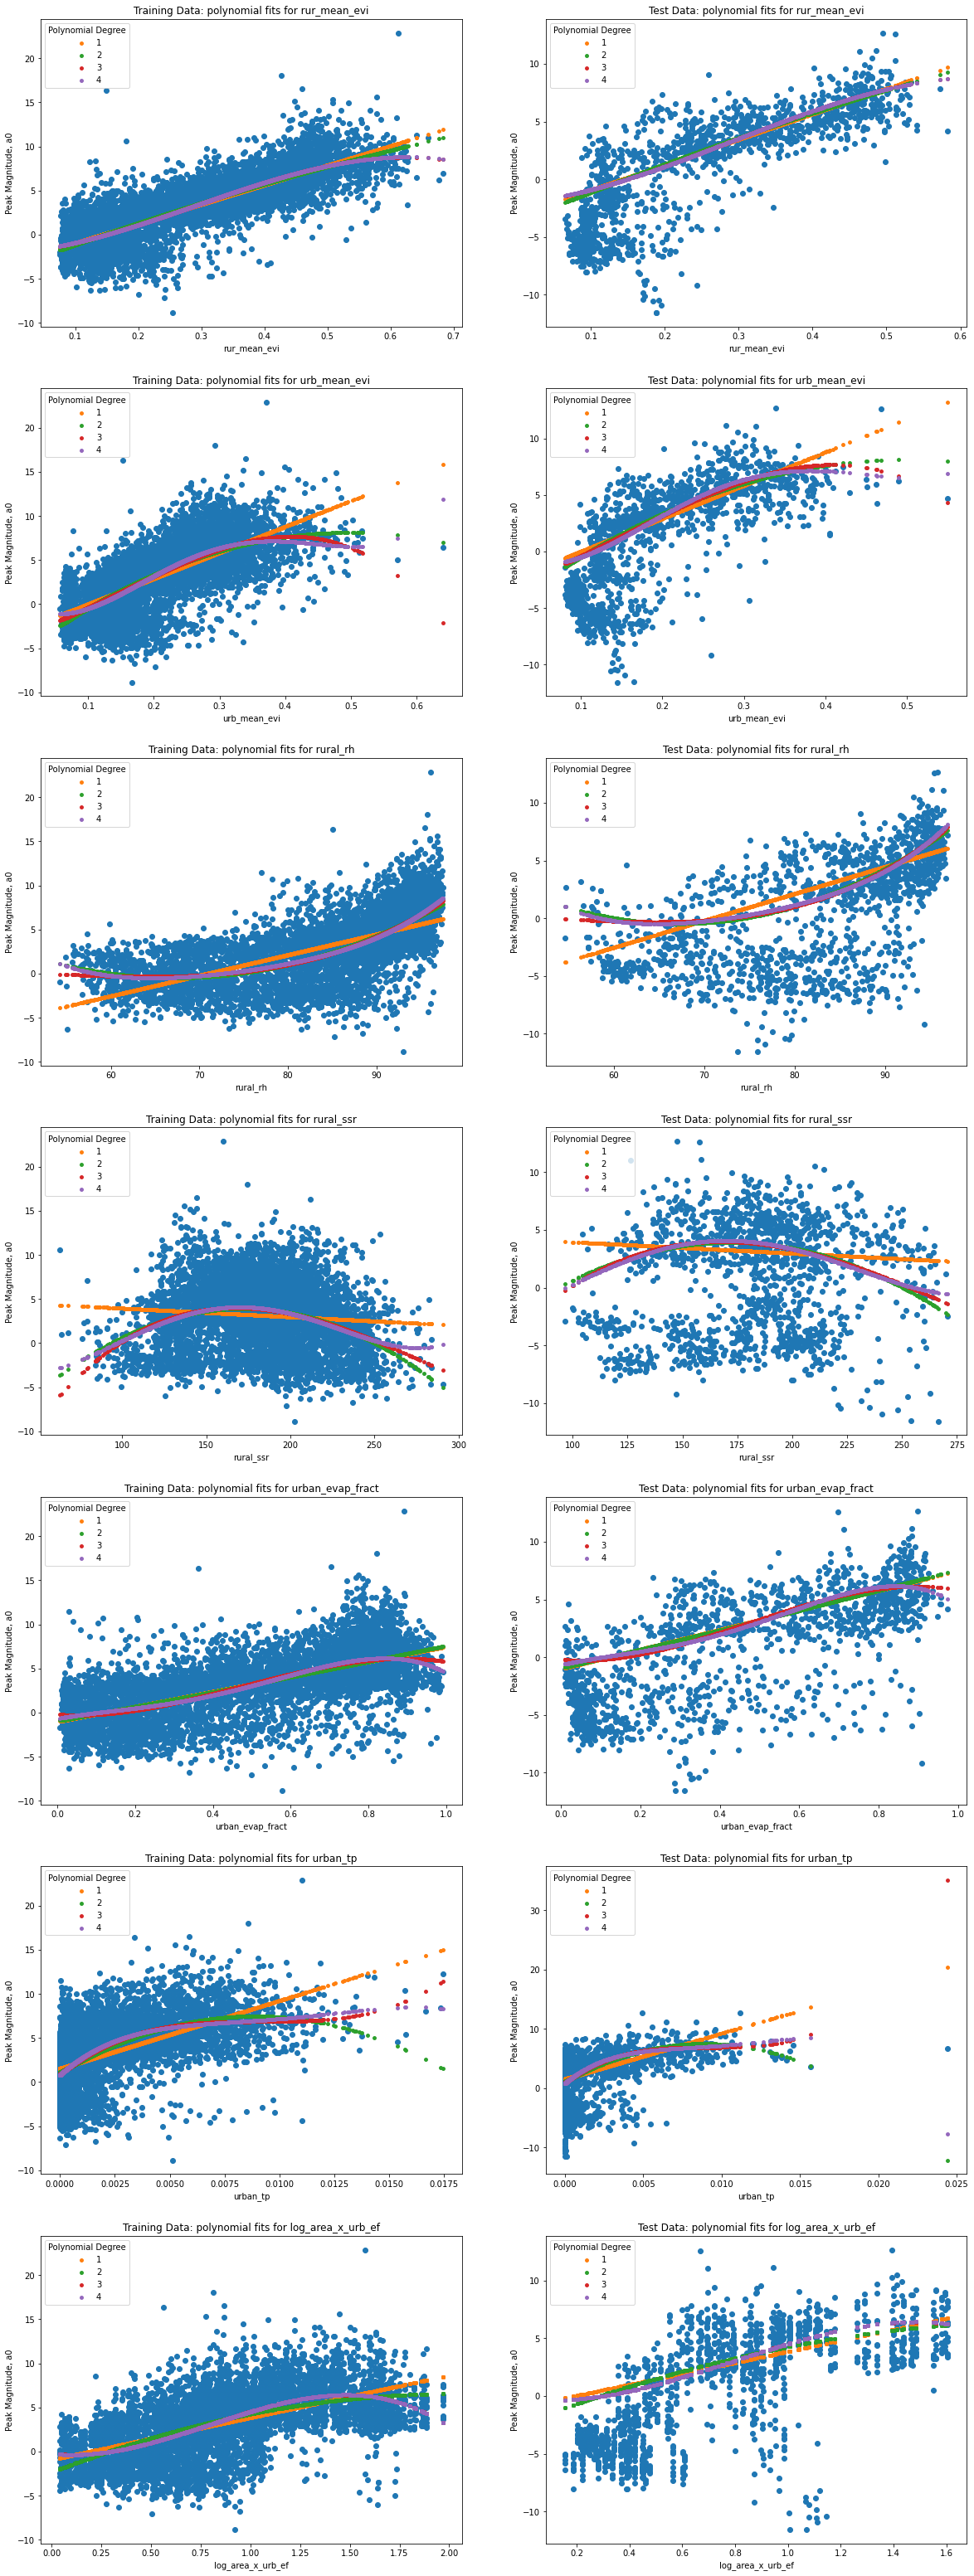

In [34]:
###### LINEAR REGRESSION ####################

#############################################
##### INPUT VARIABLES NOT NORMALISED ########
#############################################

#Linear Regression
#Looking at the individual variables 
#(includes polynomials but is linear in nature of the coefficients)
#create plots of each

#create the empty plots
num_cols = 2
num_rows = len(predictor_variables)

fig, axes = plt.subplots(num_rows,num_cols, figsize = (20, 8*num_rows))
#plt.subplots_adjust(hspace = 0.5)
#plt.subplots_adjust(wspace = 0.5)

#degrees of polynomial to fit
degrees = [1, 2,3,4]

for i1, predictor_variable in enumerate(predictor_variables):
    
    x_train = X_train[predictor_variable].values.reshape(-1, 1) #reshape due to required form
    x_test = X_test[predictor_variable].values.reshape(-1, 1)
    
    #plot the data
    #training data
    axes[i1,0].scatter(x_train, y_train)
    axes[i1,0].set(xlabel = predictor_variable, ylabel = 'Peak Magnitude, a0',
                   title = 'Training Data: polynomial fits for {}'.format(predictor_variable))
    #test data
    axes[i1,1].scatter(x_test, y_test)
    axes[i1,1].set(xlabel = predictor_variable, ylabel = 'Peak Magnitude, a0',
                   title = 'Test Data: polynomial fits for {}'.format(predictor_variable))   
    
    #create matrices to store the train and test predictions
    #each row is a data point, each column a prediction using a polynomial of some degree
    y_train_pred = np.zeros((len(x_train), len(degrees)))
    y_test_pred = np.zeros((len(x_test), len(degrees)))

    for i2, degree in enumerate(degrees):
    
        #make pipeline- create polynomial inputs, then feed them to lin reg model
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(x_train, y_train)
    
        #predict on test and train data
        #store the predictions of each degree in the corresponding column
        y_train_pred[:, i2] = model.predict(x_train)
        y_test_pred[:, i2] = model.predict(x_test)
     
        #plot the polynomials
        axes[i1,0].scatter(x_train, y_train_pred[:, i2], s=15, label=str(degree))  #training data
        axes[i1,0].legend(loc='upper left', title = 'Polynomial Degree')
        axes[i1,1].scatter(x_test, y_test_pred[:, i2], s=15, label=str(degree))    #test data
        axes[i1,1].legend(loc='upper left', title = 'Polynomial Degree')


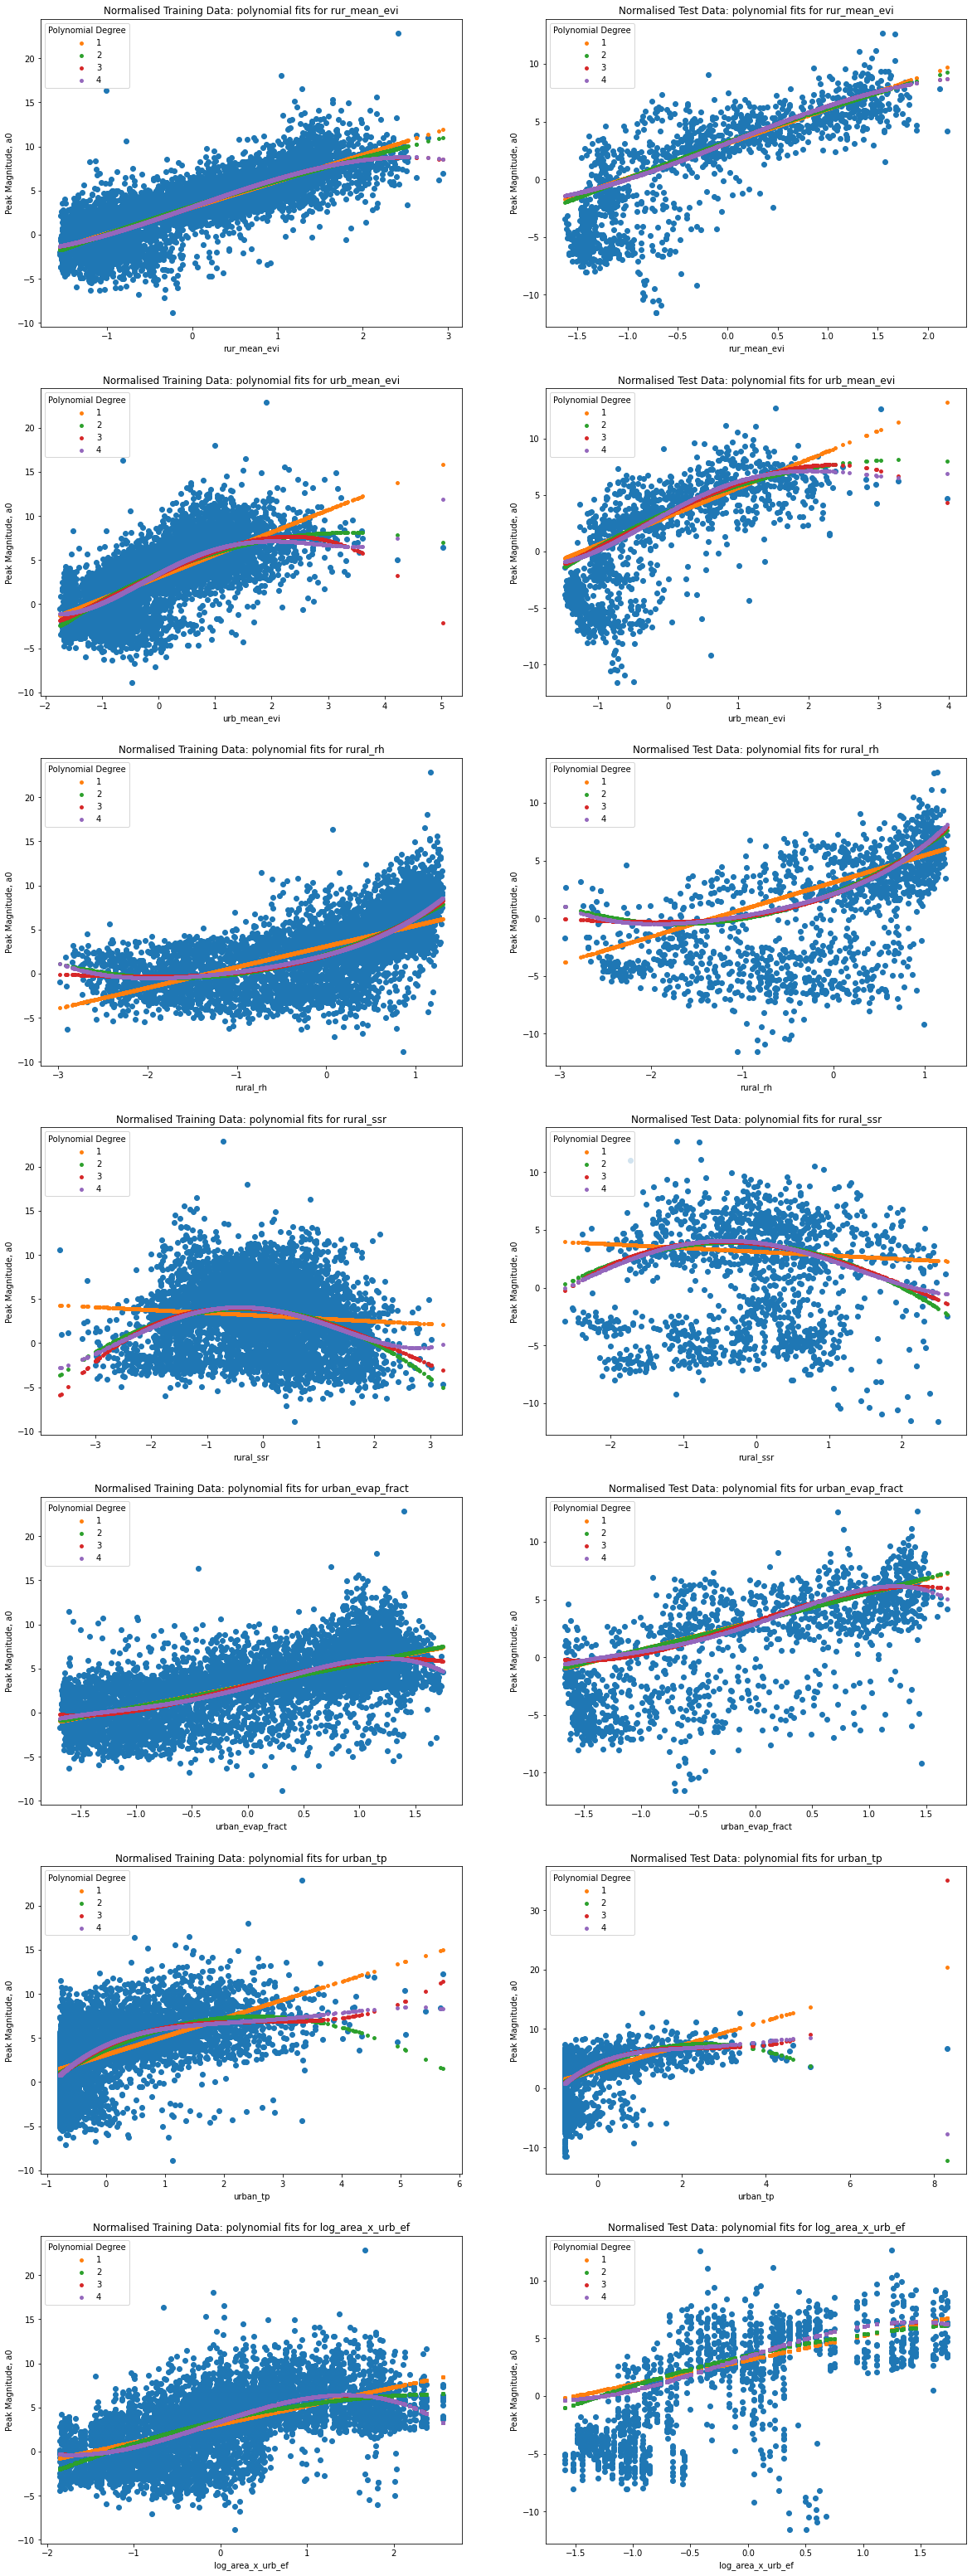

In [35]:
###### LINEAR REGRESSION ####################

#############################################
##### NORMALISED INPUT VARIABLES ############
#############################################

#Looking at the individual variables 
#(includes polynomials but is linear in nature of the coefficients)
#create plots of each

#create the empty plots
num_cols = 2
num_rows = len(predictor_variables)

fig, axes = plt.subplots(num_rows,num_cols, figsize = (20, 8*num_rows))
#plt.subplots_adjust(hspace = 0.5)
#plt.subplots_adjust(wspace = 0.5)

#degrees of polynomial to fit
degrees = [1, 2,3,4]

for i1, predictor_variable in enumerate(predictor_variables):
    
    x_train = X_train_norm[predictor_variable].values.reshape(-1, 1) #reshape due to required form
    x_test = X_test_norm[predictor_variable].values.reshape(-1, 1)
    
    #plot the data
    #training data
    axes[i1,0].scatter(x_train, y_train)
    axes[i1,0].set(xlabel = predictor_variable, ylabel = 'Peak Magnitude, a0',
                   title = 'Normalised Training Data: polynomial fits for {}'.format(predictor_variable))
    #test data
    axes[i1,1].scatter(x_test, y_test)
    axes[i1,1].set(xlabel = predictor_variable, ylabel = 'Peak Magnitude, a0',
                   title = 'Normalised Test Data: polynomial fits for {}'.format(predictor_variable))   
    
    #create matrices to store the train and test predictions
    #each row is a data point, each column a prediction using a polynomial of some degree
    y_train_pred = np.zeros((len(x_train), len(degrees)))
    y_test_pred = np.zeros((len(x_test), len(degrees)))

    for i2, degree in enumerate(degrees):
    
        #make pipeline- create polynomial inputs, then feed them to lin reg model
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(x_train, y_train)
    
        #predict on test and train data
        #store the predictions of each degree in the corresponding column
        y_train_pred[:, i2] = model.predict(x_train)
        y_test_pred[:, i2] = model.predict(x_test)
     
        #plot the polynomials
        axes[i1,0].scatter(x_train, y_train_pred[:, i2], s=15, label=str(degree)) #training data
        axes[i1,0].legend(loc='upper left', title = 'Polynomial Degree')
        axes[i1,1].scatter(x_test, y_test_pred[:, i2], s=15, label=str(degree))   #test data
        axes[i1,1].legend(loc='upper left', title = 'Polynomial Degree')


In [67]:
#Multiple Linear Regression (MLR) (degree 1 (not polynomial))

##################################
####### Creating the model #######
##################################
#Create linear regression object
lin_reg = LinearRegression()

#fit the model
lin_reg.fit(X_train_norm, y_train)

#predict the training 
y_train_pred = lin_reg.predict(X_train_norm)
#predict the test
y_test_pred = lin_reg.predict(X_test_norm)

#intercept
lin_intercept = lin_reg.intercept_
print('Intercept -- ',lin_intercept)
#coefficients
lin_coef = lin_reg.coef_
print('Coefficients--')
for i in range(len(lin_coef)):
    print(predictor_variables[i],':', lin_coef[i])

######################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_lin_mse = mean_squared_error(y_train, y_train_pred)
train_lin_rmse = np.sqrt(train_lin_mse)
#r-square
train_lin_r2 = r2_score(y_train, y_train_pred)
#mae
train_lin_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_lin_rmse, 'R-square:', train_lin_r2, 'MAE:', train_lin_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_lin_mse = mean_squared_error(y_test, y_test_pred)
test_lin_rmse = np.sqrt(test_lin_mse)
#r-square
test_lin_r2 = r2_score(y_test, y_test_pred)
#mae
test_lin_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_lin_rmse, 'R-square:', test_lin_r2, 'MAE:', test_lin_mae)

Intercept --  3.1565335349543333
Coefficients--
rur_mean_evi : 3.3779807998217035
urb_mean_evi : -0.8492206644067812
rural_ssr : 0.37956526665756674
urban_tp : 0.42540191068902
log_area_x_urb_ef : 0.3200142501090758
Training Metrics-- RMSE: 2.0931393559248224 R-square: 0.682081088201737 MAE: 1.581192722796139
Test Metrics-- RMSE: 2.916327551769096 R-square: 0.6178845330156697 MAE: 2.1897012684823567


In [68]:
#Multiple Linear Regression (MLR) (degree 1 (not polynomial))

##################################
##### SUMMARY STATISTICS #########
##################################
#Carried out again in stats models library to get the p-values (no function to calculate these in scikit learn)
X_train1 = X_train_norm.to_numpy()     #required form of X is an array
X_train2 = sm.add_constant(X_train1)   #add intercept to model
est = sm.OLS(y_train, X_train2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                     a0   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     2765.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        08:26:54   Log-Likelihood:                -13919.
No. Observations:                6451   AIC:                         2.785e+04
Df Residuals:                    6445   BIC:                         2.789e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1565      0.026    121.066      0.0

In [69]:
############################################
########## R SQUARE PLOTS BY CITY ##########
############################################

######## LINEAR REGRESSION #################

######## MAKE SURE THE  LINEAR REGRESSION MODEL HAS BEEN FIT BEFORE RUNNING THIS ##############################

#loop through each city to generate a r-square value based on the model 
cities = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] != 'Cascavel'].City.values
#cities = CITY_COUNTRY_lat_lon.City.values
r2_list = []
for i, city in enumerate(cities):
    data_city = all_monthly_data_df2[((all_monthly_data_df2['City'] == city) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

    X_data_city = data_city[predictor_variables]                                                  #predictors
    X_data_city_norm = pd.DataFrame(scaler.transform(X_data_city), columns = X_data_city.columns) #transform only
    y_data_city = data_city[target_variable]                                                      #target
    
    y_city_pred = lin_reg.predict(X_data_city_norm)
    
    r2_score_city = r2_score(y_data_city, y_city_pred)                                            #predict the r2 score
    
    r2_list.append(r2_score_city)

#create dataframe
#kg = CITY_COUNTRY_lat_lon.koppen_climate.values

#r2_df = pd.DataFrame({'city': cities, 'r2':r2_list, 'Koppen_Geiger':kg})    
r2_df = pd.DataFrame({'city': cities, 'r2':r2_list})    

In [70]:
r2_df

,city,r2
0,Huambo,0.382212
1,Anapolis,0.737102
2,Cuiaba,0.441815
3,Franca,0.676207
4,Maringa,0.388279
5,Piracicaba,0.756122
6,Ribeirao,0.465038
7,Sao_Jose_Do_Rio_Preto,0.678325
8,Linqing,0.500259
9,Akola,0.069751


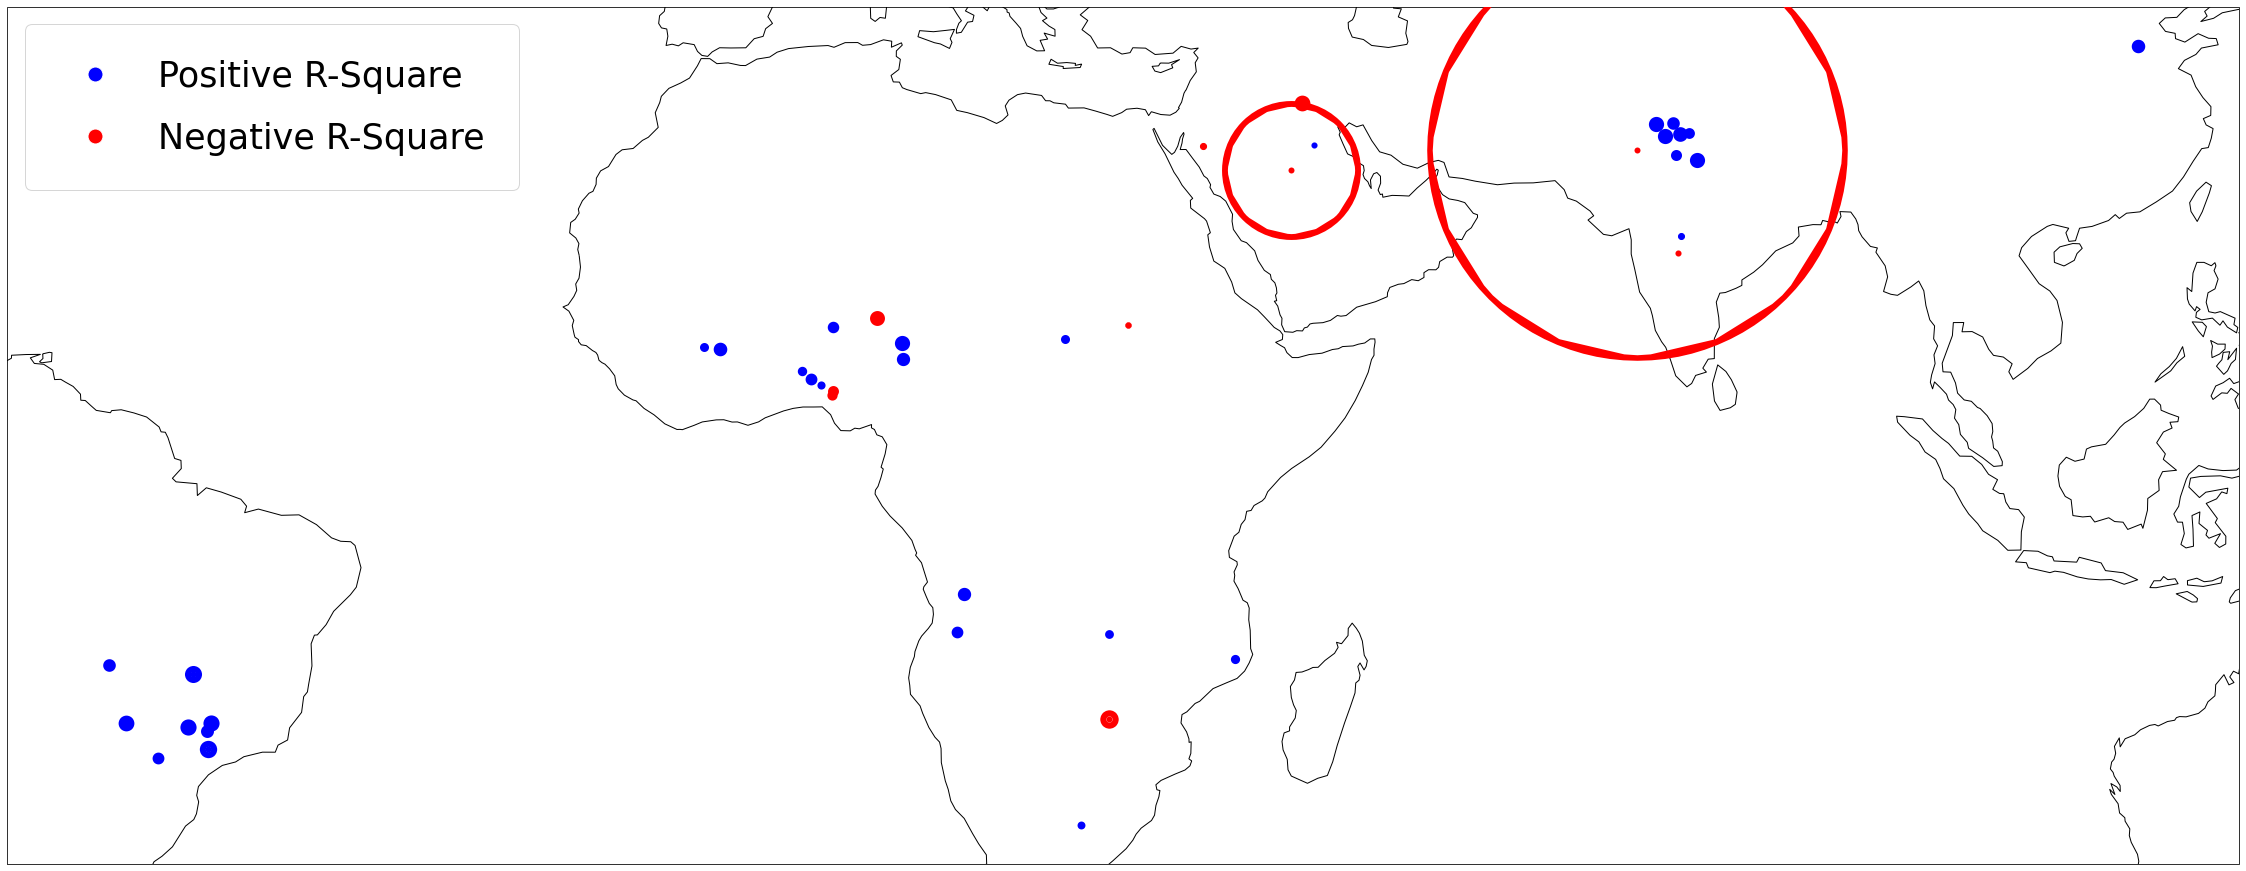

In [71]:
#Display cities with r2 proportional dot
#plot of where the test and training cities are located
fig = plt.figure(figsize=(40,35))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

for i, city in enumerate(cities):

    lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lat']
    lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lon']
    r2 = r2_df.iloc[i].r2
        
    point_size = 15*abs(r2)
    if r2 < 0:
        point_col = 'red'
    else:
        point_col = 'blue'
    
    ax.scatter(lon, lat, zorder=5,color= point_col, linewidths = point_size)

    
    
legend_elements = [Line2D([0],[0],marker='o', color = 'w', markerfacecolor='blue', label = 'Positive R-Square'
                          , markersize=15),Line2D([0],[0],marker='o', color = 'w', markerfacecolor='red'
                          , label = 'Negative R-Square' , markersize=15)]
ax.legend(handles = legend_elements, loc=2, borderpad = 1, fontsize = 35, labelspacing=0.8)                          

In [20]:
############################################
#### PERMUTATIONS OF LINEAR REGRESSIONS ####
############################################

#linear regression to test all permutations of predictor variables
#create a dataframe to fill
n = len(predictor_variables)
whole_grid = np.ones((1, n), dtype=int) #start with the case where all variables are included

for i in range(n-1):
    m = i+1
    which = np.array(list(itertools.combinations(range(n), m)))
    grid = np.zeros((len(which), n), dtype="int8")

    #add the combinations into the grid
    grid[np.arange(len(which))[None].T, which] = 1

    whole_grid = np.vstack((whole_grid, grid))
    
all_models = pd.DataFrame(data = whole_grid, columns = predictor_variables) #create a dataframe with all the combinations
all_models['AIC'] = np.nan           #add in the test statistics
all_models['Ftest_pvalue']= np.nan
all_models['rmse'] = np.nan
all_models['rsquared'] = np.nan
all_models['test_rmse'] = np.nan
all_models['test_rsquared'] = np.nan

#go through the table and calculate test statistics for models including combinations of pred variables
for i in range(len(all_models)):
    row = all_models.iloc[i] #take the row
    variable_list = []
    for p, predictor in enumerate(predictor_variables):
        if row[p] == 1:
            variable_list.append(predictor)         #create list of the variables which are used in the row
    
    X_train_temp = X_train_norm[variable_list]      #select the train variables to be used
    X_test_temp = X_test_norm[variable_list]
    #not using test data for model validation/ selection as it must remain untouched
    #carry out the linear regression
    X_train_temp1 = X_train_temp.to_numpy()         #required form of X is an array
    X_train_temp2 = sm.add_constant(X_train_temp1)  #add intercept to model
    
    est = sm.OLS(y_train, X_train_temp2)
    est2 = est.fit()
    y_train_pred = est2.predict(X_train_temp2)
    
    #calculate the y test prediction
    
    X_test_temp1 = X_test_temp.to_numpy()                     #required form of X is an array
    X_test_temp2 = sm.add_constant(X_test_temp1)              #add intercept to model
    y_test_pred = est2.predict(X_test_temp2)                  #predict the test dataset
    
    #add in the test statistics
    all_models.loc[i,'AIC'] =  est2.aic                                 #AIC
    all_models.loc[i,'Ftest_pvalue']= est2.f_pvalue                     #f statistic p value
    all_models.loc[i,'rmse'] = rmse(y_train, y_train_pred)              #train rmse
    all_models.loc[i,'rsquared'] =est2.rsquared                         #train r square
    all_models.loc[i,'test_rmse'] = rmse(y_test, y_test_pred)           #test rmse
    all_models.loc[i,'test_rsquared'] = r2_score(y_test, y_test_pred)   #test r square
    
    
#save the table as a pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','predictive_models')) 
with open('all_variables_lin_reg.pkl', 'wb') as f:
    pickle.dump(all_models, f)

#for each number of predictor variables, select the model with the best r-squared
#add in the number of variables used in each model
all_models['num_variables'] = all_models[predictor_variables].sum(axis = 1)

#create empty dataframe to be filled
best_models = pd.DataFrame()
#select the models for each variable which have the best r-square
#best_models 
for i in range(len(predictor_variables)):
    max_rsquare = max(all_models[all_models['num_variables'] == (i+1)].rsquared)
    rows = all_models[(all_models['rsquared'] == max_rsquare)& (all_models['num_variables'] == (i+1))]
    best_models = best_models.append(rows)

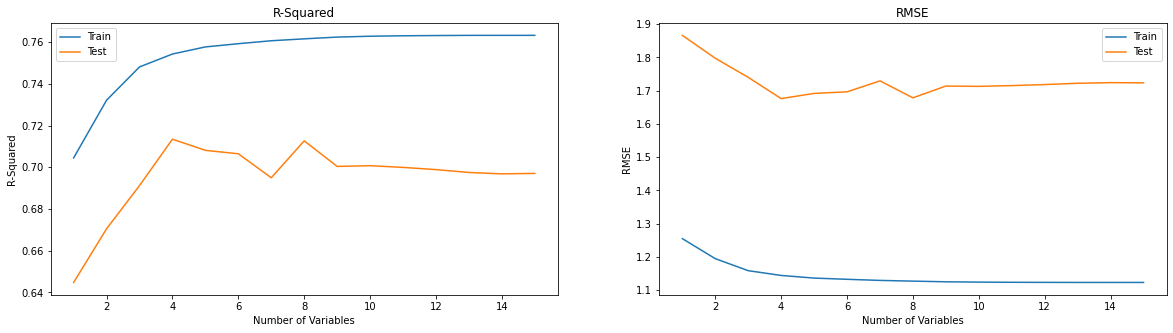

In [21]:
#plot the number of variables against the r-squared, AIC and rmse
fig, axes = plt.subplots(1,2, figsize = (20, 5))
axes[0].plot(best_models.num_variables, best_models.rsquared, label = 'Train')
axes[0].plot(best_models.num_variables, best_models.test_rsquared, label = 'Test')
axes[0].set(xlabel = 'Number of Variables', ylabel = 'R-Squared', title = 'R-Squared')
axes[0].legend()

axes[1].plot(best_models.num_variables, best_models.rmse, label = 'Train')
axes[1].plot(best_models.num_variables, best_models.test_rmse, label = 'Test')
axes[1].set(xlabel = 'Number of Variables', ylabel = 'RMSE', title = 'RMSE')
axes[1].legend()

xa = axes[0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
xa = axes[1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

In [28]:
best_models.iloc[5]

urban_evap_fract         0.000000
urban_rh                 0.000000
rural_evap_fract         0.000000
rural_rh                 0.000000
rural_tp                 1.000000
urban_tp                 0.000000
rural_t2m                0.000000
urban_t2m                0.000000
rural_ssr                1.000000
urban_ssr                0.000000
rur_mean_evi             1.000000
urb_mean_evi             1.000000
log_area_x_rur_ef        0.000000
log_area_x_urb_ef        1.000000
Eccentricity             1.000000
AIC                  21311.398511
Ftest_pvalue             0.000000
rmse                     1.132920
rsquared                 0.759254
test_rmse                1.696388
test_rsquared            0.706479
num_variables            6.000000
Name: 9730, dtype: float64

In [461]:
#Using cross validation to determine the number of variables used (the hyperparameter in this case)
n = len(predictor_variables) 
#cross-validation scheme, 5 fold
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, n+1))}]

#perform grid search

lin_reg = LinearRegression()           #specify model
lin_reg.fit(X_train_norm, y_train)     #fit the model 
rfe = RFE(lin_reg)                     #feature selection

#Use cross validation
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train_norm, y_train)  

#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.007189,0.002700,0.001595,0.000489,1,{'n_features_to_select': 1},0.595548,0.597881,0.594870,0.524084,...,0.572900,0.029781,5,0.569962,0.569406,0.568987,0.586660,0.580518,0.575107,0.007200
1,0.005377,0.001188,0.001997,0.000898,2,{'n_features_to_select': 2},0.657208,0.650170,0.648522,0.600784,...,0.631845,0.024822,4,0.627992,0.629694,0.629229,0.641109,0.641251,0.633855,0.006007
2,0.004787,0.000746,0.002194,0.000746,3,{'n_features_to_select': 3},0.729576,0.683184,0.703721,0.664467,...,0.681839,0.034448,3,0.673320,0.684535,0.678444,0.688749,0.697642,0.684538,0.008395
3,0.002989,0.000004,0.001810,0.000757,4,{'n_features_to_select': 4},0.743096,0.683246,0.720789,0.671848,...,0.693936,0.033494,2,0.685960,0.700330,0.689914,0.702713,0.707964,0.697376,0.008190
4,0.002584,0.000482,0.001397,0.000488,5,{'n_features_to_select': 5},0.746809,0.686207,0.726311,0.668576,...,0.695970,0.035465,1,0.688410,0.702963,0.691571,0.706641,0.710980,0.700113,0.008704


In [450]:
model_cv.best_params_

{'n_features_to_select': 5}

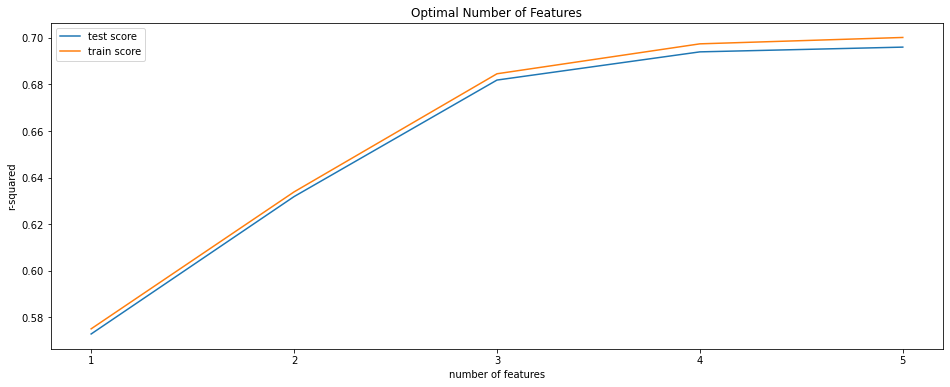

In [451]:
# plotting cv results
fig, axes = plt.subplots(1,1, figsize = (16, 6))

axes.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
axes.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
axes.set(xlabel= 'number of features', ylabel='r-squared', title = "Optimal Number of Features")
axes.legend(['test score', 'train score'], loc='upper left')
xa = axes.get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

In [20]:
#Multiple Linear Regression (MLR) (degree 2 (polynomial))
##################################
####### Creating the model #######
##################################

#create polynomial inputs, 
poly_features = PolynomialFeatures(degree = 2)
X_poly = poly_features.fit_transform(X_train_norm)

#create the lin reg model
lin_reg = LinearRegression()

#then feed polynomials to lin reg model
lin_reg.fit(X_poly, y_train)
#predict the training 
y_train_pred = lin_reg.predict(X_poly)
#predict the test
X_poly_test = poly_features.fit_transform(X_test_norm)
y_test_pred = lin_reg.predict(X_poly_test)

#intercept
lin_intercept = lin_reg.intercept_
print('Intercept -- ',lin_intercept)
#coefficients
poly_predictor_vars = poly_features.get_feature_names(predictor_variables)
lin_coef = lin_reg.coef_
print('Coefficients--')
for i in range(len(lin_coef)):
    print(poly_predictor_vars[i],':',lin_coef[i])

######################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_lin_mse = mean_squared_error(y_train, y_train_pred)
train_lin_rmse = np.sqrt(train_lin_mse)
#r-square
train_lin_r2 = r2_score(y_train, y_train_pred)
#mae
train_lin_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_lin_rmse, 'R-square:', train_lin_r2, 'MAE:', train_lin_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_lin_mse = mean_squared_error(y_test, y_test_pred)
test_lin_rmse = np.sqrt(test_lin_mse)
#r-square
test_lin_r2 = r2_score(y_test, y_test_pred)
#mae
test_lin_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_lin_rmse, 'R-square:', test_lin_r2, 'MAE:', test_lin_mae)

Intercept --  3.789049122943683
Coefficients--
1 : 0.0
rur_mean_evi : 2.9412229946701993
urban_evap_fract : 0.04450023971265443
rural_ssr : 0.5081372754395473
rur_mean_evi^2 : -0.34103853754348923
rur_mean_evi urban_evap_fract : 0.5534391662946676
rur_mean_evi rural_ssr : 0.6414592204989376
urban_evap_fract^2 : -0.2605622600844957
urban_evap_fract rural_ssr : -0.13688406607500747
rural_ssr^2 : -0.12128474032171421
Training Metrics-- RMSE: 2.1694283864659467 R-square: 0.6568953148889736 MAE: 1.675189247430664
Test Metrics-- RMSE: 2.79741784278168 R-square: 0.45449809896627935 MAE: 1.9611765820015963


Ridge Regression

In [38]:
##########################
#### RIDGE REGRESSION ####
##########################

folds = 5    #define the number of folds (K)

#define regression model
ridge_reg = Ridge(fit_intercept=True)
#specify the hyperparameters to test
hyper_params = {'alpha':[1, 10, 20,30,40,50,60,70,80,90, 100]}
#use cross validation to determine the hyperparameter value
model_cv = GridSearchCV(estimator = ridge_reg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
#fit the model~
model_cv.fit(X_train_norm, y_train)  

#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003791,0.000977,0.002194,7.458691e-04,1,{'alpha': 1},0.692863,0.560345,0.651063,0.325420,...,0.539986,0.131930,1,0.694838,0.667568,0.703230,0.719274,0.691335,0.695249,0.016868
1,0.003989,0.000631,0.002593,4.891663e-04,10,{'alpha': 10},0.692142,0.557255,0.651945,0.322753,...,0.538896,0.132675,2,0.694699,0.667353,0.703050,0.719088,0.691175,0.695073,0.016877
2,0.003600,0.000792,0.001785,9.670037e-04,20,{'alpha': 20},0.691132,0.552775,0.652472,0.318733,...,0.537103,0.133727,3,0.694313,0.666764,0.702553,0.718581,0.690726,0.694587,0.016901
3,0.002792,0.000400,0.001994,8.921234e-04,30,{'alpha': 30},0.689944,0.547438,0.652607,0.313872,...,0.534831,0.134965,4,0.693723,0.665885,0.701800,0.717825,0.690036,0.693854,0.016939
4,0.002992,0.000631,0.002592,4.883259e-04,40,{'alpha': 40},0.688613,0.541446,0.652419,0.308386,...,0.532188,0.136349,5,0.692963,0.664781,0.700839,0.716875,0.689143,0.692920,0.016986
5,0.003986,0.000632,0.002992,6.307517e-04,50,{'alpha': 50},0.687168,0.534958,0.651965,0.302443,...,0.529260,0.137847,6,0.692063,0.663502,0.699712,0.715774,0.688082,0.691827,0.017041
6,0.002990,0.001092,0.001997,6.342254e-04,60,{'alpha': 60},0.685634,0.528101,0.651293,0.296176,...,0.526116,0.139435,7,0.691048,0.662088,0.698450,0.714556,0.686880,0.690604,0.017103
7,0.003990,0.000001,0.002991,9.246216e-07,70,{'alpha': 70},0.684031,0.520977,0.650439,0.289687,...,0.522810,0.141092,8,0.689938,0.660572,0.697080,0.713249,0.685560,0.689280,0.017168
8,0.004388,0.000487,0.002792,3.989460e-04,80,{'alpha': 80},0.682376,0.513666,0.649437,0.283057,...,0.519387,0.142802,9,0.688750,0.658981,0.695625,0.711875,0.684142,0.687875,0.017237
9,0.003797,0.000403,0.002985,6.311228e-04,90,{'alpha': 90},0.680682,0.506232,0.648312,0.276347,...,0.515882,0.144551,10,0.687500,0.657335,0.694102,0.710451,0.682644,0.686406,0.017308


In [39]:
#Performance stats for ridge regression
y_train_pred = model_cv.predict(X_train_norm)
y_test_pred = model_cv.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_ridge_mse = mean_squared_error(y_train, y_train_pred)
train_ridge_rmse = np.sqrt(train_ridge_mse)
#r-square
train_ridge_r2 = r2_score(y_train, y_train_pred)
#mae
train_ridge_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_ridge_rmse, 'R-square:', train_ridge_r2, 'MAE:', train_ridge_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_ridge_mse = mean_squared_error(y_test, y_test_pred)
test_ridge_rmse = np.sqrt(test_ridge_mse)
#r-square
test_ridge_r2 = r2_score(y_test, y_test_pred)
#mae
test_ridge_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_ridge_rmse, 'R-square:', test_ridge_r2, 'MAE:', test_ridge_mae)


Training Metrics-- RMSE: 2.0209223006175843 R-square: 0.6998928624926961 MAE: 1.5455051771034418
Test Metrics-- RMSE: 2.667696848045143 R-square: 0.5083087968855803 MAE: 1.7653874755272045


Random Forest regression (RFR)

In [115]:
##################################
#### RANDOM FOREST REGRESSION ####
##################################

forest_reg = RandomForestRegressor()                                  #define the model

#carry out cross validation
folds = 5                                                             #define the number of folds (K)
#specify the hyperparameters to test
#num_features_for_split = total_input_features/3
hyper_params = {'n_estimators':[5,10,20,40,60,80,100]                 #the number of trees
                ,'max_depth':[10,20,30,40,50,60,70,80,90,100,None]    #the tree depth
                ,'min_samples_leaf':[1,2,4,15]                        #min number of samples required at each leaf node
                ,'min_samples_split':[2,5,10,15] }                    #min number of samples required to split a node

#use cross validation to determine the hyperparameter value
model_cv = GridSearchCV(estimator = forest_reg, 
                        param_grid = hyper_params, 
                        #scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,                                  #verbose- how detailed output is   
                        return_train_score=True) 
#fit the model
model_cv.fit(X_train_norm, y_train)  

#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 5 folds for each of 1232 candidates, totalling 6160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 6160 out of 6160 | elapsed: 140.0min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.136632,0.006016,0.002195,0.000399,10,1,2,5,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.523491,...,0.482328,0.099313,1134,0.851998,0.886012,0.885493,0.869823,0.875830,0.873831,0.012499
1,0.279056,0.017143,0.003389,0.000486,10,1,2,10,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.582886,...,0.517630,0.087307,900,0.857659,0.898794,0.898676,0.881300,0.885711,0.884428,0.015083
2,0.546533,0.014858,0.004990,0.000017,10,1,2,20,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.570977,...,0.515785,0.097410,926,0.867670,0.901909,0.899518,0.884571,0.886214,0.887976,0.012283
3,1.034914,0.005087,0.006971,0.000620,10,1,2,40,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.565207,...,0.524114,0.094440,758,0.869397,0.903916,0.903284,0.886704,0.891884,0.891037,0.012678
4,1.559233,0.011079,0.010565,0.001359,10,1,2,60,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.567942,...,0.522966,0.096401,794,0.869926,0.904801,0.905402,0.889670,0.892993,0.892558,0.012928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,0.462884,0.010785,0.004183,0.000744,None,15,15,20,"{'max_depth': None, 'min_samples_leaf': 15, 'm...",0.556735,...,0.531982,0.095557,395,0.805251,0.848320,0.839753,0.819077,0.817725,0.826025,0.015712
1228,0.980816,0.068879,0.006773,0.000745,None,15,15,40,"{'max_depth': None, 'min_samples_leaf': 15, 'm...",0.555440,...,0.529814,0.094834,528,0.806102,0.849734,0.841965,0.820855,0.821340,0.827999,0.015762
1229,1.400271,0.027514,0.009172,0.000401,None,15,15,60,"{'max_depth': None, 'min_samples_leaf': 15, 'm...",0.555630,...,0.533406,0.093182,319,0.807451,0.851425,0.841659,0.822368,0.823196,0.829220,0.015524
1230,1.896758,0.073835,0.011968,0.000631,None,15,15,80,"{'max_depth': None, 'min_samples_leaf': 15, 'm...",0.565762,...,0.538328,0.093115,70,0.807978,0.850862,0.842511,0.821120,0.823003,0.829095,0.015495


In [116]:
cv_results[cv_results['rank_test_score'] < 10].sort_values(by = ['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
772,0.463166,0.010896,0.004188,0.000399,70,15,10,20,"{'max_depth': 70, 'min_samples_leaf': 15, 'min...",0.565864,...,0.543407,0.092811,1,0.803879,0.849528,0.839937,0.820542,0.819052,0.826588,0.016208
837,1.792023,0.047467,0.011151,0.000982,80,2,15,60,"{'max_depth': 80, 'min_samples_leaf': 2, 'min_...",0.593584,...,0.543193,0.091311,2,0.893018,0.915768,0.911599,0.900212,0.902147,0.904549,0.008162
887,1.849676,0.030988,0.011367,0.000491,80,15,10,80,"{'max_depth': 80, 'min_samples_leaf': 15, 'min...",0.561519,...,0.542858,0.091210,3,0.806931,0.851759,0.841779,0.821699,0.823311,0.829095,0.015836
444,0.941483,0.058286,0.006782,0.000399,40,15,15,40,"{'max_depth': 40, 'min_samples_leaf': 15, 'min...",0.561975,...,0.542543,0.091523,4,0.807337,0.849995,0.840378,0.819416,0.822144,0.827854,0.015309
90,2.289152,0.091663,0.013956,0.001251,10,15,2,100,"{'max_depth': 10, 'min_samples_leaf': 15, 'min...",0.558709,...,0.542476,0.089538,5,0.794083,0.844081,0.834997,0.813407,0.818024,0.820918,0.017434
69,2.575224,0.121157,0.015957,0.000631,10,4,5,100,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_...",0.574771,...,0.542306,0.090007,6,0.848883,0.887839,0.883918,0.868563,0.871218,0.872084,0.013709
662,1.381698,0.024893,0.008773,0.000750,60,15,10,60,"{'max_depth': 60, 'min_samples_leaf': 15, 'min...",0.553170,...,0.542289,0.088644,7,0.806974,0.850866,0.842857,0.821471,0.822149,0.828864,0.015867
445,1.403049,0.057656,0.009176,0.000746,40,15,15,60,"{'max_depth': 40, 'min_samples_leaf': 15, 'min...",0.558636,...,0.542278,0.089540,8,0.807161,0.850744,0.842034,0.820815,0.822216,0.828594,0.015696
982,0.464565,0.010842,0.003989,0.000002,90,15,2,20,"{'max_depth': 90, 'min_samples_leaf': 15, 'min...",0.563649,...,0.542109,0.093093,9,0.802917,0.849173,0.839843,0.819287,0.820542,0.826352,0.016344


In [117]:
#Performance stats for random forest regression
y_train_pred = model_cv.predict(X_train_norm)
y_test_pred = model_cv.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_forest_mse = mean_squared_error(y_train, y_train_pred)
train_forest_rmse = np.sqrt(train_forest_mse)
#r-square
train_forest_r2 = r2_score(y_train, y_train_pred)
#mae
train_forest_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_forest_rmse, 'R-square:', train_forest_r2, 'MAE:', train_forest_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_forest_mse = mean_squared_error(y_test, y_test_pred)
test_forest_rmse = np.sqrt(test_forest_mse)
#r-square
test_forest_r2 = r2_score(y_test, y_test_pred)
#mae
test_forest_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_forest_rmse, 'R-square:', test_forest_r2, 'MAE:', test_forest_mae)


Training Metrics-- RMSE: 1.5441482594898357 R-square: 0.826827078389227 MAE: 1.103768961508581
Test Metrics-- RMSE: 3.156034340456769 R-square: 0.552145735377203 MAE: 2.4081583987270263


In [119]:
model_cv.best_params_

{'max_depth': 70,
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'n_estimators': 20}

In [120]:
##### FEATURE IMPORTANCE ####
##  enter the cv parameters in to the model ##
model = RandomForestRegressor(n_estimators=20, min_samples_leaf=15, min_samples_split = 10, max_depth = 70)
model.fit(X_train_norm, y_train)

for name, importance in zip(X_train.columns, model.feature_importances_):
    print (name, ':',importance)

urban_evap_fract : 0.004612810094516185
urban_rh : 0.010201765243944743
rural_evap_fract : 0.007058131017093507
rural_rh : 0.010533602612488476
rural_tp : 0.009816647057543423
urban_tp : 0.006939181803040756
rural_t2m : 0.010159900559766242
urban_t2m : 0.01401456650148378
rural_ssr : 0.01729851990035247
urban_ssr : 0.013124604923408351
rur_mean_evi : 0.8145388534403514
urb_mean_evi : 0.015224463752979913
log_area_x_rur_ef : 0.010527825155260233
log_area_x_urb_ef : 0.035913944353270826
Eccentricity : 0.020035183584499867


Text(0.5, 0, 'Relative Importance')

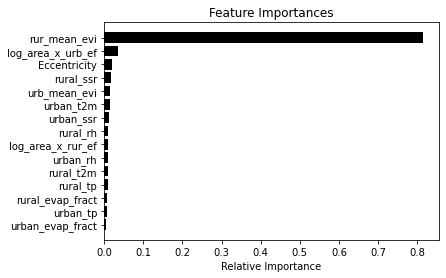

In [122]:
# plot the feature importance #
features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='k', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

Gaussian Process Regression

In [85]:
#############################################
######## GAUSSIAN PROCESS REGRESSION ########
#############################################

gpr = GaussianProcessRegressor()               # define the model

RBF_kernel = RBF()                             # define the kernels
Dot_Product_kernel = DotProduct()
Matern_kernel = Matern()
#carry out cross validation
folds = 5                                                                       #define the number of folds (K)
#specify the hyperparameters to test
#num_features_for_split = total_input_features/3
hyper_params = [{'kernel':[RBF_kernel]                # using the RBF kernel
                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    # e-10 is the default alpha (value added to cov matrix diagonal)
                ,'n_restarts_optimizer':[20]          # number of restarts for the optimizer to find kernels parameters    
            } ,{'kernel':[Dot_Product_kernel]         # using the dot prod kernel
                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    
                ,'n_restarts_optimizer':[20] 
            }  ,{'kernel':[Matern_kernel]             # using the Matern kernel
                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    
                ,'n_restarts_optimizer':[20] 
            }]                 

model_cv = GridSearchCV(estimator = gpr, 
                        param_grid = hyper_params, 
                        #scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,                                  #verbose- how detailed output is   
                        return_train_score=True) 

#fit the model
model_cv.fit(X_train_norm, y_train_norm)  

#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Anaconda3\envs\project_environment\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Anaconda3\envs\project_environment\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Anaconda3\envs\project_environment\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Inc

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_kernel,param_n_restarts_optimizer,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,655.473504,110.617701,0.226795,0.034234,0.01,RBF(length_scale=1),20,"{'alpha': 0.01, 'kernel': RBF(length_scale=1),...",-2.872657,-0.135983,...,-0.793055,1.097675,9,0.999550,0.998789,0.998983,0.998933,0.999310,0.999113,2.772331e-04
1,1087.232821,219.379525,0.321143,0.046242,0.001,RBF(length_scale=1),20,"{'alpha': 0.001, 'kernel': RBF(length_scale=1)...",-3.065478,-0.279315,...,-0.935212,1.138513,10,0.999996,0.999986,0.999989,0.999988,0.999983,0.999988,4.362061e-06
2,1374.459657,300.973869,0.265891,0.058616,0.00001,RBF(length_scale=1),20,"{'alpha': 1e-05, 'kernel': RBF(length_scale=1)...",-3.081598,-0.301105,...,-0.953518,1.139425,11,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.447063e-10
3,1290.124951,411.802652,0.290433,0.020179,0.0,RBF(length_scale=1),20,"{'alpha': 1e-10, 'kernel': RBF(length_scale=1)...",-3.081756,-0.301314,...,-0.953697,1.139432,12,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
4,2336.409161,935.107601,0.068417,0.019014,0.01,DotProduct(sigma_0=1),20,"{'alpha': 0.01, 'kernel': DotProduct(sigma_0=1...",0.547589,0.466402,...,0.554246,0.069123,4,0.626693,0.697106,0.680969,0.659483,0.637248,0.660300,2.624259e-02
5,743.549245,253.051476,0.055651,0.004820,0.001,DotProduct(sigma_0=1),20,"{'alpha': 0.001, 'kernel': DotProduct(sigma_0=...",0.572359,0.462084,...,0.560630,0.069193,2,0.627892,0.696291,0.680614,0.659903,0.644007,0.661742,2.455002e-02
6,621.016102,89.764006,0.057844,0.003679,0.00001,DotProduct(sigma_0=1),20,"{'alpha': 1e-05, 'kernel': DotProduct(sigma_0=...",0.573039,0.436417,...,0.557727,0.076152,3,0.628060,0.690927,0.681060,0.660325,0.643121,0.660699,2.324964e-02
7,416.640678,113.272875,0.056647,0.004653,0.0,DotProduct(sigma_0=1),20,"{'alpha': 1e-10, 'kernel': DotProduct(sigma_0=...",0.566244,0.473534,...,0.561902,0.065110,1,0.628205,0.698164,0.681071,0.655836,0.643874,0.661430,2.521316e-02
8,709.252723,440.899608,0.243350,0.028857,0.01,"Matern(length_scale=1, nu=1.5)",20,"{'alpha': 0.01, 'kernel': Matern(length_scale=...",-0.875533,0.200989,...,-0.080718,0.450427,5,0.999574,0.999498,0.999565,0.999573,0.999684,0.999579,5.963564e-05
9,677.085815,228.725459,0.232388,0.024485,0.001,"Matern(length_scale=1, nu=1.5)",20,"{'alpha': 0.001, 'kernel': Matern(length_scale...",-1.054635,0.180761,...,-0.139309,0.510512,6,0.999994,0.999992,0.999994,0.999993,0.999996,0.999994,1.100549e-06


In [87]:
model_cv.best_params_

{'alpha': 1e-10, 'kernel': DotProduct(sigma_0=1), 'n_restarts_optimizer': 20}

In [86]:
#Performance stats for random forest regression
y_train_pred = model_cv.predict(X_train_norm)
y_test_pred = model_cv.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_gpr_mse = mean_squared_error(y_train, y_train_pred)
train_gpr_rmse = np.sqrt(train_gpr_mse)
#r-square
train_gpr_r2 = r2_score(y_train, y_train_pred)
#mae
train_gpr_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_gpr_rmse, 'R-square:', train_gpr_r2, 'MAE:', train_gpr_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_gpr_mse = mean_squared_error(y_test, y_test_pred)
test_gpr_rmse = np.sqrt(test_gpr_mse)
#r-square
test_gpr_r2 = r2_score(y_test, y_test_pred)
#mae
test_gpr_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_gpr_rmse, 'R-square:', test_gpr_r2, 'MAE:', test_gpr_mae)


Training Metrics-- RMSE: 2.1472849577717352 R-square: 0.6654204137812629 MAE: 1.6511818192402274
Test Metrics-- RMSE: 3.000892247973156 R-square: 0.5954028505114692 MAE: 2.2806151383654782


In [ ]:
#generalised additive model (GAM) 